<a href="https://colab.research.google.com/github/jacKlinc/movie-recommender/blob/main/08_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
# fastbook.setup_book()

In [ ]:
#hide
from fastbook import *

# Collaborative Filtering Deep Dive

## A First Look at the Data

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
last_skywalker = np.array([0.98,0.9,-0.9])

In [ ]:
user1 = np.array([0.9,0.8,-0.6])

In [ ]:
(user1*last_skywalker).sum()

2.1420000000000003

In [ ]:
casablanca = np.array([-0.99,-0.3,0.8])

In [ ]:
(user1*casablanca).sum()

-1.611

Minimum and maximum scores

In [ ]:
action_user = np.array([1., 1., 1.])
action_film = np.array([1., 1., 1.])

non_action_user = np.array([0, 0, 0])
non_action_film = np.array([0, 0, 0])

(action_user * action_film).sum(), (non_action_user * non_action_film).sum()

(3.0, 0)

## Learning the Latent Factors

## Creating the DataLoaders

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
pd.crosstab(ratings.user, ratings.movie)

movie,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,...,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,16

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,311,Nell (1994),4
1,479,Notorious (1946),5
2,276,Kids in the Hall: Brain Candy (1996),3
3,381,I Don't Want to Talk About It (De eso no se habla) (1993),4
4,190,Eye for an Eye (1996),2
5,577,"Kid in King Arthur's Court, A (1995)",3
6,405,Nine Months (1995),1
7,867,"Great Dictator, The (1940)",5
8,922,"Fish Called Wanda, A (1988)",4
9,776,"Big Sleep, The (1946)",2


In [ ]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [ ]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [ ]:
one_hot_3 = one_hot(3, n_users).float()

In [ ]:
user_factors.t() @ one_hot_3

tensor([ 0.6832, -0.3406, -1.1592,  0.1003, -1.1625])

In [ ]:
user_factors[3]

tensor([ 0.6832, -0.3406, -1.1592,  0.1003, -1.1625])

In [ ]:
len(one_hot_3)

944

## Collaborative Filtering from Scratch

In [ ]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

In [ ]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

In [ ]:
x = Example('Jack')
x.say('hi')

'Hello Jack, hi.'

In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        # batch is [0], so use [1]
        return (users * movies).sum(dim=1)

In [ ]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [ ]:
x

tensor([[ 495,  271],
        [ 682,  211],
        [ 543,  816],
        [ 843,   45],
        [ 537,  877],
        [ 616,  767],
        [ 279, 1414],
        [ 903,  611],
        [ 880,   12],
        [ 781,   51],
        [ 246,   17],
        [  49,  320],
        [ 782, 1276],
        [  89,  632],
        [ 405, 1550],
        [ 787, 1365],
        [  43, 1045],
        [ 472, 1505],
        [ 609, 1008],
        [ 412, 1462],
        [ 100,  461],
        [ 699,  953],
        [ 181,  340],
        [ 755, 1319],
        [ 942,  537],
        [ 514,  646],
        [ 398,  617],
        [ 512, 1302],
        [ 318,  874],
        [ 373,  556],
        [ 676, 1468],
        [ 734,  415],
        [ 654, 1524],
        [ 297, 1343],
        [ 561, 1296],
        [ 606, 1455],
        [ 822,  580],
        [ 222,  769],
        [ 256,  770],
        [  92,  885],
        [ 356,  767],
        [ 297,  769],
        [ 457,  155],
        [ 710,  696],
        [ 545, 1462],
        [ 

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.312570,1.273203,00:07
1,1.089192,1.077788,00:07
2,0.949340,0.970437,00:07
3,0.886620,0.878087,00:07
4,0.798307,0.862134,00:07


In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.982745,0.969051,00:07
1,0.898885,0.881615,00:07
2,0.687155,0.849832,00:07
3,0.476383,0.858474,00:07
4,0.383168,0.862852,00:07


In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        # account for snobby/ users
        self.user_bias = Embedding(n_users, 1)
        # account for very good/bad
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.958765,0.923866,00:08
1,0.831202,0.849443,00:08
2,0.633082,0.844299,00:08
3,0.399733,0.870013,00:08
4,0.297996,0.878263,00:08


### Weight Decay

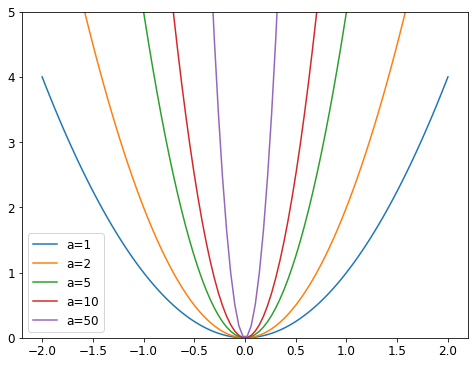

In [ ]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.972840,0.927433,00:08
1,0.848622,0.860909,00:08
2,0.750494,0.818578,00:08
3,0.598908,0.804073,00:08
4,0.506144,0.805255,00:07


### Creating Our Own Embedding Module

In [ ]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [ ]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [ ]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[0.3612],
        [0.9674],
        [0.5367]], requires_grad=True)]

In [ ]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [ ]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [ ]:
create_params([5, 5])

Parameter containing:
tensor([[ 0.0077,  0.0075, -0.0104,  0.0221, -0.0022],
        [-0.0060, -0.0032, -0.0034,  0.0030,  0.0052],
        [ 0.0024, -0.0084, -0.0286,  0.0201, -0.0016],
        [ 0.0029, -0.0041,  0.0118, -0.0089,  0.0071],
        [ 0.0061,  0.0056, -0.0164,  0.0126,  0.0112]], requires_grad=True)

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.995954,0.941385,00:08
1,0.853673,0.864105,00:08
2,0.765575,0.821004,00:08
3,0.563370,0.805690,00:08
4,0.493794,0.806577,00:08


## Interpreting Embeddings and Biases

In [ ]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Crow: City of Angels, The (1996)',
 'Island of Dr. Moreau, The (1996)',
 'Robocop 3 (1993)',
 'Big Bully (1996)']

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Star Wars (1977)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Good Will Hunting (1997)']

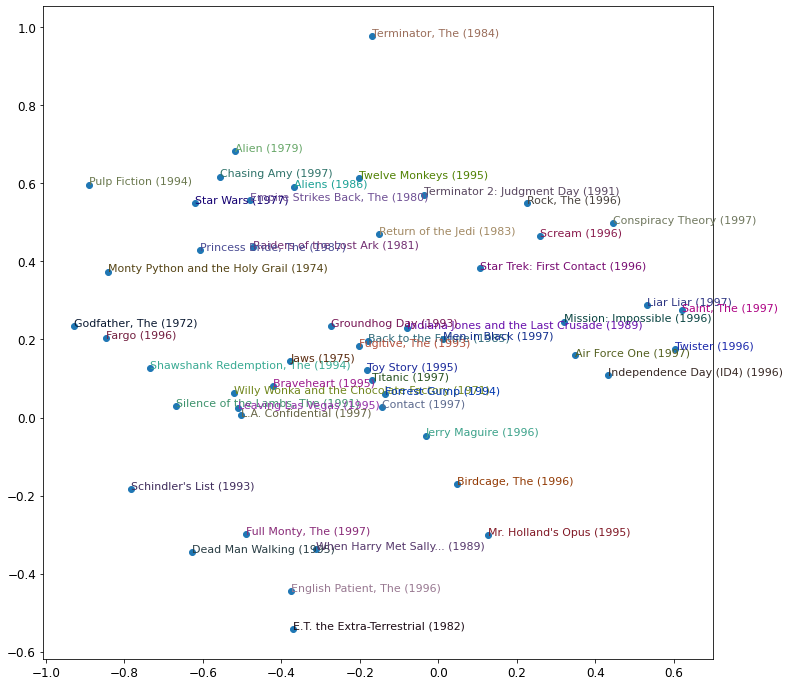

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Using fastai.collab

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.929577,0.929476,00:08
1,0.855832,0.862249,00:08
2,0.736866,0.811525,00:08
3,0.567219,0.799420,00:08
4,0.496063,0.799952,00:08


In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [ ]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Star Wars (1977)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Godfather, The (1972)']

### Embedding Distance

In [ ]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[2]
dls.classes['title'][idx]

'For Whom the Bell Tolls (1943)'

In [ ]:
dls.classes['title'][idx]

'For Whom the Bell Tolls (1943)'

## Bootstrapping a Collaborative Filtering Model

## Deep Learning for Collaborative Filtering

In [ ]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [ ]:
model = CollabNN(*embs)

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.928078,0.952652,00:08
1,0.885988,0.889776,00:08
2,0.866848,0.868723,00:08
3,0.815606,0.856452,00:08
4,0.784670,0.857722,00:08


In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.978608,0.952066,00:10
1,0.944559,0.909104,00:10
2,0.871832,0.869527,00:10
3,0.826118,0.839815,00:10
4,0.763745,0.842857,00:10


In [ ]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

### Sidebar: kwargs and Delegates

### End sidebar

## Conclusion

## Questionnaire

1. What problem does collaborative filtering solve?
  - Product recommendations based on similar user's usage
  
1. How does it solve it?
  - Using a user's latent factors which combined with other users can learn what they like and what they might like
  
1. Why might a collaborative filtering predictive model fail to be a very useful recommendation system?
  - It might recommend products that the user has already seen
  
1. What does a crosstab representation of collaborative filtering data look like?
  - A matrix where each cell represents the matrix dot product of a user's sentiment of that product
  
1. Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).
  `pd.crosstab(ratings.user, ratings.movie)`
  
1. What is a latent factor? Why is it "latent"?
  - A factor that is not given to the model explicitly, rather learned to predict recommendations
  
1. What is a dot product? Calculate a dot product manually using pure Python with lists.
  - Calculates the sum of a matrix product
  ```python
  l1 = [1, 2, 5]
  l2 = [3, 5, 6]
  [i * j for i, j in zip(l1, l2)]
  ```
  
1. What does `pandas.DataFrame.merge` do?
  - Joins two DataFrames on a column
  
1. What is an embedding matrix?
  - The embedding matrix is what is the one-hot-encoded vectors are multiplied by to make predictions
  
1. What is the relationship between an embedding and a matrix of one-hot-encoded vectors?
  - The embedding is a matrix of OHE vectors stacked for computational efficiency
  
1. Why do we need `Embedding` if we could use one-hot-encoded vectors for the same thing?
  - Efficiency. The multiplication of the OHC vectors is the same as indexing in an Embedding.
  
1. What does an embedding contain before we start training (assuming we're not using a pretained model)?
  - Randomly initialised values
  
1. Create a class (without peeking, if possible!) and use it.
  ```python
  class MyClass:
    def __init__(self, x):
        self.x = x
    def square(self, x):
        return self.x ** 2
  
  c1 = MyClass(2)
  c1.square(2)
  ```
  
1. What does `x[:,0]` return?
  - All rows of the 0th column
  
1. Rewrite the `DotProduct` class (without peeking, if possible!) and train a model with it.
  ```python
  class DotProduct():
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self):
        users = self.user_factors[:, 0]
        movies = self.movies_factors[:, 1]
        return (users * movies).sum(dim=1)
  ```
  
1. What is a good loss function to use for MovieLens? Why? 
  - MSE. 
  - The targets are numeric
  
1. What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?
  - The model output would need to make 5 predictions so that CrossEntropy can get the loss
  
1. What is the use of bias in a dot product model?
  - To account for outlying users 
  
1. What is another name for weight decay?
  - L2 Regularisation
  
1. Write the equation for weight decay (without peeking!).
  
  `wd_loss = loss + wd * (params ** 2).sum()`
  
1. Write the equation for the gradient of weight decay. Why does it help reduce weights?
  ```parameters.grad += wd * 2 * parameters```
  - The higher the weight decay the narrower the canyons are in the loss-parameter curve
  
1. Why does reducing weights lead to better generalization?
  - Results in shallower and smoother surfaces, preventing overfitting.
  
1. What does `argsort` do in PyTorch?
  - Returns a Tensor's indices in their original order
  
1. Does sorting the movie biases give the same result as averaging overall movie ratings by movie? Why/why not?
  - Averaging the rating defeats the purpose of using collaborative filtering. The biases are what make it "filtering".
  
1. How do you print the names and details of the layers in a model?
  
  `learn.model`
  
1. What is the "bootstrapping problem" in collaborative filtering?
  - When a model has insufficient data to make any recommendation, AKA cold start.
  
1. How could you deal with the bootstrapping problem for new users? For new movies?
  - Collect data for new entries
  
1. How can feedback loops impact collaborative filtering systems?
  - Outlying users may be very active in a niche causing representation bias in that area
  
1. When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?
  - Rather than getting the dot product (size must match), embedding matrices are concatenated
  
1. Why is there an `nn.Sequential` in the `CollabNN` model?
  - nn.Sequential allows the use of multiple `Module` layers
  
1. What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?
  - Tabular data
  

### Further Research

1. Take a look at all the differences between the `Embedding` version of `DotProductBias` and the `create_params` version, and try to understand why each of those changes is required. If you're not sure, try reverting each change to see what happens. (NB: even the type of brackets used in `forward` has changed!)
1. Find three other areas where collaborative filtering is being used, and find out what the pros and cons of this approach are in those areas.
1. Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forum for ideas. Note that there are more columns in the full dataset—see if you can use those too (the next chapter might give you ideas).
1. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.